## ARISE-GERI data analysis


*import libraries*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime 
from scipy import interpolate
import statistics


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.options.display.max_rows = 50

### Data

insert patient and trial of interest

In [4]:
patient_nr = 'P12'
filename = 'B_p12_trial_8_211124_144902'

**H-MAN sensor data (FILE_ID.dat)**

files are saved accordingly ...../data/ARISE_GERI/P12/(filename)

In [5]:
df = pd.read_csv('./data/ARISE_GERI/' + patient_nr + '/' + filename + '.dat', sep='\t+', header=[1])
df

,Time_msec,RawDataX,RawDataY,RawDataTorqueLeft,RawDataTorqueRight
0,1,0.171179,0.210688,0.000000,0.000000
1,2,0.171179,0.210688,0.000000,0.000000
2,3,0.171179,0.210688,0.000000,0.000000
3,4,0.171179,0.210688,0.000000,0.000000
4,5,0.171179,0.210688,0.000000,0.000000
...,...,...,...,...,...
710602,1517306,0.145016,0.214483,0.004852,0.344329
710603,1517307,0.145041,0.214558,-0.004846,0.354030
710604,1517308,0.145041,0.214558,0.000000,0.349183
710605,1517309,0.145016,0.214634,0.004849,0.363732


In [6]:
df.columns = df.columns.str.lower()

**Time-stamped data (FILE_ID.tsd)**

In [7]:
tsd = pd.read_csv('./data/ARISE_GERI/' + patient_nr + '/' + filename + '.tsd', sep='\t+', header=[1])
tsd

,t,event_type,Obstacles/Outcome
0,20,service_event_start,0
1,9560,retrieval,0
2,14475,outcome_type,1
3,14480,service_event_end,1
4,14480,service_event_start,0
...,...,...,...
621,1509580,retrieval,0
622,1511430,collision,2
623,1517320,outcome_type,1
624,1517325,service_event_end,1


In [8]:
tsd.columns = tsd.columns.str.replace(' ','')
tsd.columns = tsd.columns.str.replace('/','_')
tsd.columns = tsd.columns.str.lower() 

In [9]:
tsd['event_type'].unique()

array(['service_event_start', 'retrieval', 'outcome_type',
       'service_event_end', 'collision'], dtype=object)

In [10]:
tsd[tsd['event_type']=='outcome_type']['obstacles_outcome'].value_counts()

1    140
2      4
3      4
Name: obstacles_outcome, dtype: int64

what is 'outcome_type'? 

**Game parameters (FILE_ID.par)**

In [11]:
par = pd.read_csv('./data/ARISE_GERI/' + patient_nr + '/' + filename + '.par', header=[0])

In [12]:
# converting to one column 
par.set_axis(['gameparameters'], axis=1, inplace=True)
par = par['gameparameters'].str.split(' ', expand=True)
par = par.rename(columns={0: 'gameparameter'})
par[3][0:7] = par[2][0:7]
par[2][0:7] = ''
cols1 = ['gameparameter', 1, 2]
par['gameparameter'] = par[cols1].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
par.drop(columns=[1,2],inplace=True)
cols2 = [3,4,5,6]
par.iloc[7:10][3] = par[cols2].apply(lambda row: ','.join(row.values.astype(str)), axis=1)
par.drop(columns=[4,5,6],inplace=True)
par = par.rename(columns={3: 'value'})

In [13]:
par

,gameparameter,value
0,CustomerCount:,12
1,SessionTimeout:,60
2,FadeOutTime:,15
3,CustomerArrivalTime:,4
4,TotalBlocks:,12
5,CognitiveLevel:,1
6,HapticsLevel:,3
7,DampingMatrixA:,"100,200,0,0"
8,DampingMatrixB:,"0,0,0,0"
9,DampingMatrixC:,"-30,-30,30,0"


**Researcher reports (FILE_ID.rep)**

In [14]:
rep = pd.read_csv('./data/ARISE_GERI/' + patient_nr + '/' + filename + '.rep', header=[0])

In [15]:
# converting to one column 
rep.set_axis(['patientid'], axis=1, inplace=True)
rep = rep['patientid'].str.split(' ', n=1, expand=True)
rep = rep.rename(columns={0 : 'parameter', 1 : 'value'})
rep['value'] = rep['value'].str.replace(' ','')

In [16]:
rep

,parameter,value
0,Patient,ID:p12_trial
1,SessionTerminationCondition,Completed
2,SessionDuration,25.23
3,sumofOutcomesType1,140
4,sumofOutcomesType2,4
5,sumofOutcomesType3,4
6,TotalCustomersServed,144
7,AverageReactionTime,6.349509
8,AverageSpeed,2
9,CollisionRate,0


**quality timestamp check**

In [17]:
diff = abs(tsd['t'].iloc[-1] - df['time_msec'].iloc[-1])
if diff > 10:
    print(f'{diff}, TIME DISCREPANCY IN DATA')
else:
    print('pass')

15, TIME DISCREPANCY IN DATA


### EDA

#### wrt svc_event

##### interpolate sensor data

**merge main**

In [18]:
main = pd.merge(tsd, df, how='left', left_on='t', right_on='time_msec')
main

,t,event_type,obstacles_outcome,time_msec,rawdatax,rawdatay,rawdatatorqueleft,rawdatatorqueright
0,20,service_event_start,0,20.0,0.171179,0.210688,0.000000,0.000000
1,9560,retrieval,0,NaN,NaN,NaN,NaN,NaN
2,14475,outcome_type,1,14475.0,0.200660,0.218554,0.000002,0.116392
3,14480,service_event_end,1,NaN,NaN,NaN,NaN,NaN
4,14480,service_event_start,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
621,1509580,retrieval,0,1509580.0,0.146649,0.054815,0.000000,0.000000
622,1511430,collision,2,1511430.0,0.114128,0.093821,0.121242,0.460726
623,1517320,outcome_type,1,NaN,NaN,NaN,NaN,NaN
624,1517325,service_event_end,1,NaN,NaN,NaN,NaN,NaN


In [19]:
## fix missing NaN by using nearest timestamp
for idx, time in enumerate(main['time_msec']):
    if pd.isna(time):
        t1=main['t'].iloc[idx]
        temp = df.loc[(df['time_msec']<=(t1+15)) & (df['time_msec']>=(t1-15))]
        min_=15
        for time in temp['time_msec']:
            min_ = min(abs(time-t1),min_)
            main_min_ = t1-min_
        if main_min_ in temp['time_msec'].values:
            main_min_ = main_min_
        else:
            main_min_ = t1+min(abs(time-t1),min_)
        main['time_msec'].iloc[idx] = temp.loc[temp['time_msec']==main_min_]['time_msec']
        main['rawdatax'].iloc[idx] = temp.loc[temp['time_msec']==main_min_]['rawdatax']
        main['rawdatay'].iloc[idx] = temp.loc[temp['time_msec']==main_min_]['rawdatay']


In [22]:
# index service_event start/end in main
nr = 0
main['sequence'] = 0
for index, event in enumerate(main['event_type']):
    if event == 'service_event_end':
        main['sequence'].iloc[index] = nr
        nr += 1   
    else:
        main['sequence'].iloc[index] = nr
        

##### mean speed 

In [23]:
svc_event = main[main['event_type'].str.contains('service_event')]
svc_event

,t,event_type,obstacles_outcome,time_msec,rawdatax,rawdatay,rawdatatorqueleft,rawdatatorqueright,sequence
0,20,service_event_start,0,20.0,0.171179,0.210688,0.0,0.0,0
3,14480,service_event_end,1,14475.0,0.200660,0.218554,NaN,NaN,0
4,14480,service_event_start,0,14475.0,0.200660,0.218554,NaN,NaN,1
7,24650,service_event_end,1,24645.0,0.263542,0.214483,NaN,NaN,1
8,24650,service_event_start,0,24645.0,0.263542,0.214483,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...
616,1492045,service_event_start,0,1492046.0,0.197644,0.215287,NaN,NaN,146
619,1500165,service_event_end,1,1500166.0,0.271358,0.214759,NaN,NaN,146
620,1500165,service_event_start,0,1500166.0,0.271358,0.214759,NaN,NaN,147
624,1517325,service_event_end,1,1517310.0,0.145041,0.214659,NaN,NaN,147


In [25]:
# check sequence for each service event
svc_event.head(10)

,t,event_type,obstacles_outcome,time_msec,rawdatax,rawdatay,rawdatatorqueleft,rawdatatorqueright,sequence
0,20,service_event_start,0,20.0,0.171179,0.210688,0.000000,0.000000,0
3,14480,service_event_end,1,14475.0,0.200660,0.218554,NaN,NaN,0
4,14480,service_event_start,0,14475.0,0.200660,0.218554,NaN,NaN,1
7,24650,service_event_end,1,24645.0,0.263542,0.214483,NaN,NaN,1
8,24650,service_event_start,0,24645.0,0.263542,0.214483,NaN,NaN,2
11,30805,service_event_end,1,30805.0,0.077107,0.214131,0.009697,0.106695,2
12,30805,service_event_start,0,30805.0,0.077107,0.214131,0.009697,0.106695,3
15,37620,service_event_end,1,37621.0,0.211417,0.214181,NaN,NaN,3
16,37620,service_event_start,0,37621.0,0.211417,0.214181,NaN,NaN,4
19,53175,service_event_end,1,53176.0,0.286714,0.213628,NaN,NaN,4


In [26]:
svc_event[['time_diff','x_diff','y_diff']]=svc_event.groupby('sequence')[['time_msec','rawdatax','rawdatay']].diff()
svc_event['step_size'] = np.sqrt(svc_event['x_diff']**2+svc_event['y_diff']**2)
svc_event['speed'] = (svc_event['step_size'])/(svc_event['time_diff']/1000)
svc_event.drop(columns=['rawdatatorqueleft','rawdatatorqueright'],inplace=True)
svc_event = svc_event.dropna()

mean_speed = statistics.mean(svc_event['speed'])

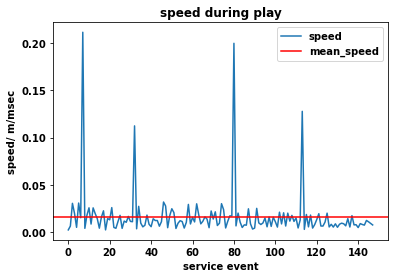

In [27]:
# plot speed and mean_speed
plt.plot('sequence','speed',data=svc_event);
plt.axhline(y=mean_speed, color='r', linestyle='-')
plt.legend(['speed','mean_speed'])
plt.xlabel('service event')
plt.ylabel('speed/ m/msec')
plt.title('speed during play'); 

In [28]:
# quality check 
# rep['TotalCustomersServed']
total_svc =  int(rep['value'][6])
total_svc

144

**how does the system determine a correction/rectification made?**


##### service event errors rate

 1 (Correct item & correct person in sequence) 
 <br> 2 (Correct item & wrong person in sequence)
 <br> 3 (Wrong item & wrong person in sequence).

In [29]:
svc_error = main[main['event_type']=='service_event_end']['obstacles_outcome'].unique()
svc_error

array([1, 3, 2], dtype=int64)

In [30]:
svc_event.reset_index(inplace=True)
total_svc = int(svc_event['sequence'].tail(1))
if 2 in svc_error:
    svc_error_2 = svc_event[svc_event['obstacles_outcome']==2]['obstacles_outcome'].count()
else:
    svc_error_2 = 0
if 3 in svc_error:
    svc_error_3 = svc_event[svc_event['obstacles_outcome']==3]['obstacles_outcome'].count()
else:
    svc_error_3 = 0

In [31]:
error_rate = (svc_error_2 + svc_error_3)/total_svc
error_rate

0.05442176870748299

##### collision rate

collisions=1 if shelf
<br> collisions=2 if object

In [32]:
main[main['event_type'].str.contains('collision')]['obstacles_outcome'].value_counts()

1    30
2     7
Name: obstacles_outcome, dtype: int64

In [33]:
coll_1 = main[(main['event_type']=='collision') & (main['obstacles_outcome']==1)]['obstacles_outcome'].count()
coll_2 = main[(main['event_type']=='collision') & (main['obstacles_outcome']==2)]['obstacles_outcome'].count()

collision_rate = (coll_1 + coll_2)/total_svc
collision_rate

0.25170068027210885

#### moving averages

##### mean speed (rolling)

In [34]:
# set sequence as index
svc_event.set_index('sequence', inplace=True)

# just in case
svc_event.sort_index(inplace=True)

In [35]:
# define window
window = int(input("window: "))

window: 7


In [36]:
# moving average
svc_event['speed_7']=svc_event['speed'].rolling(window).mean()

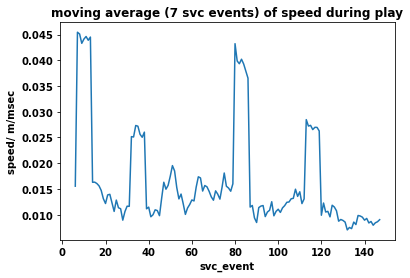

In [37]:
# plot moving average
plt.plot('speed_7',data=svc_event);
plt.xlabel('svc_event')
plt.ylabel('speed/ m/msec')
plt.title(f'moving average ({window} svc events) of speed during play'); 

##### svc event errors rate (rolling)

In [38]:
## define window
# window = int(input("window: "))

In [39]:
svc_event['error_rate'] = np.nan
for i in range(0,(len(svc_event)-window+1)):
    svc_error = svc_event[svc_event['event_type']=='service_event_end']['obstacles_outcome'][i:i+window].unique()
    if 2 in svc_error:
        svc_error_2 = svc_event[i:i+window][svc_event['obstacles_outcome']==2]['obstacles_outcome'].count()
    else:
        svc_error_2 = 0
    if 3 in svc_error:
        svc_error_3 = svc_event[i:i+window][svc_event['obstacles_outcome']==3]['obstacles_outcome'].count()
    else:
        svc_error_3 = 0
    svc_event['error_rate'][i+window] = (svc_error_2 + svc_error_3)/window

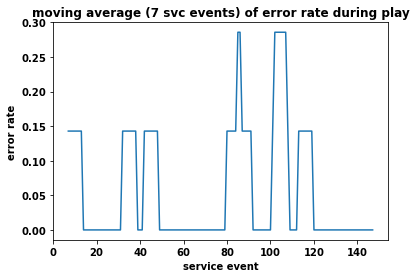

In [40]:
# plot moving average
plt.plot('error_rate',data=svc_event);
plt.xlabel('service event')
plt.ylabel('error rate')
plt.title(f'moving average ({window} svc events) of error rate during play'); 

##### total collision (svc)

In [41]:
# define collision df
collision = main[main['event_type'].str.contains('collision|service')]

In [43]:
# collision 1
coll_1 = collision[(collision['event_type']=='collision') & (collision['obstacles_outcome']==1)].groupby('sequence').count()[['obstacles_outcome']]
coll_1 = coll_1.rename(columns={'obstacles_outcome':'coll_1'})

# collision 2
coll_2 = collision[(collision['event_type']=='collision') & (collision['obstacles_outcome']==2)].groupby('sequence').count()[['obstacles_outcome']]
coll_2 = coll_2.rename(columns={'obstacles_outcome':'coll_2'})

# total collisions
total_coll = pd.merge(coll_1, coll_2, how='left', on='sequence').replace(np.nan,0)
total_coll = total_coll.reindex(range(0,total_coll.index.astype(int)[-1]+1), fill_value=0)
total_coll['total_coll'] = total_coll['coll_1'] + total_coll['coll_2']

In [44]:
# mean total obstacles
mean_total_obstacles = statistics.mean(total_coll['total_coll'])

In [45]:
total_coll

,coll_1,coll_2,total_coll
sequence,,,
0,0,0.0,0.0
1,0,0.0,0.0
2,0,0.0,0.0
3,0,0.0,0.0
4,0,0.0,0.0
...,...,...,...
138,0,0.0,0.0
139,0,0.0,0.0
140,0,0.0,0.0


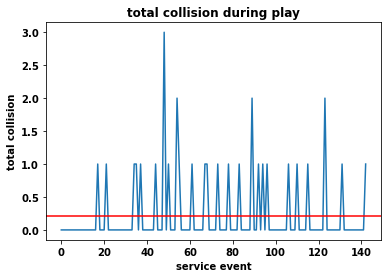

In [46]:
# plot total collision per svc_event
plt.plot('total_coll',data=total_coll);
plt.axhline(y=mean_total_obstacles, color='r', linestyle='-')
plt.xlabel('service event')
plt.ylabel('total collision')
plt.title('total collision during play'); 

In [47]:
# quality check
collision[collision['sequence']==48]

,t,event_type,obstacles_outcome,time_msec,rawdatax,rawdatay,rawdatatorqueleft,rawdatatorqueright,sequence
196,440215,service_event_start,0,440216.0,0.214432,0.213880,NaN,NaN,48
197,443630,collision,1,443620.0,0.320870,0.123276,NaN,NaN,48
198,445635,collision,1,445635.0,0.207923,0.059640,0.063046,-0.21824,48
199,446110,collision,1,446111.0,0.200886,0.048381,NaN,NaN,48
202,454440,service_event_end,1,454441.0,0.151023,0.213352,NaN,NaN,48


##### total collision (rolling)

In [48]:
## define window
# window = int(input("window: "))

In [49]:
total_coll['total_coll7']=total_coll['total_coll'].rolling(window).mean()

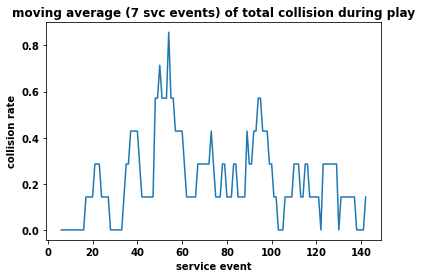

In [50]:
# plot moving average
plt.plot('total_coll7',data=total_coll);
plt.xlabel('service event')
plt.ylabel('collision rate')
plt.title(f'moving average ({window} svc events) of total collision during play'); 

### export data to csv

In [51]:
# mean_speed
# error_rate
# collision_rate
# mean_speed(rolling)
# error_rate(rolling)
# collision_rate(rolling)

with open('result_' + patient_nr + '.csv', mode='a') as file_:
    file_.write("{},{},{}".format(mean_speed, error_rate, collision_rate))
    file_.write("\n")  